# Capstone 2 - Clustering DV Data
***

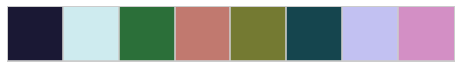

In [1]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

import xgboost as xgb
from xgboost import plot_importance

# Setup pandas
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
palette = sns.color_palette("cubehelix", 8)
palette = [palette[0],palette[7],palette[2],palette[4],palette[3],palette[1],palette[6],palette[5]]
sns.set_palette(palette)
sns.palplot(palette)


In [2]:
#Record start time of processing
start = datetime.datetime.now()

# Loading data into df
csv = 'interviewed_women.csv'
dfi = pd.read_csv(csv, low_memory=False)

#Record end time of processing
end = datetime.datetime.now()
print("Duration:", end - start)

Duration: 0:01:35.977104


In [3]:
#dfi.head()
dfi.shape

(79729, 4797)

In [4]:
# Check that df includes variables of interest

# Load data dictionary csv, which contains information like column definitions and intended uses
data_dict = pd.read_csv('data_dict.csv')

# Get list of interesting columns from data_dict
interesting_cols = list(data_dict['variable'][data_dict['use'].notnull()])

# Get list of columns in dfi
dfi_cols = list(dfi.columns.unique())

# Get list of interesting columns that are not in dfi
not_in_dfi = [item for item in interesting_cols if item not in dfi]
print("Interesting columns not in dfi:", not_in_dfi)

# V044 Selection for Domestic Violence Module (Only women interviewed for dv module were kept.)
print(dfi.v044.unique())

# Were all women interviewed, or just women who had ever been married?
print(dfi.v020.unique())

dfi.shape

Interesting columns not in dfi: []
['woman selected and interviewed']
['all woman sample']


(79729, 4797)

In [5]:
# Create df with only columns of interest from dfi
interesting_in_dfi = [item for item in interesting_cols if item in dfi]
df = dfi[interesting_in_dfi]
df = df.loc[df['v502'] == 'currently in union/living with a man',:]
print("Shape of df:", df.shape)

# Get list of interesting columns that are not in df
not_in_df = [item for item in interesting_cols if item not in df]
print("Interesting columns not in df:", not_in_df)

Shape of df: (62716, 149)
Interesting columns not in df: []


In [6]:
def q_union_status(items):
    u = []
    for item in items:
        u.append({ 'column': item
              ,'in_union': np.where('yes' in list(df[df.v502=='currently in union/living with a man'][item].unique()),1,0)
              ,'former_union': np.where('yes' in list(df[df.v502=='formerly in union/living with a man'][item].unique()),1,0)
              ,'never_union': np.where('yes' in list(df[df.v502=='never in union [includes: married gauna not performed]'][item].unique()),1,0)
             })
    df_union = pd.DataFrame(u)
    return df_union
    display(df_union)


In [7]:
m = np.mean(np.where((df.d108.isin(['yes',1])) |(df.d107.isin(['yes',1])) |(df.d106.isin(['yes',1])) |(df.d104.isin(['yes',1])) , 1, 0))
m

0.31293449837362075

## Cleaning the Data
***
Helpful [article](https://www.edupristine.com/blog/k-means-algorithm) for k-means pre-processing.

In [8]:
# Rename columns for easier interpretation
col_name_dict = {'d106':'dv_phys_less'
                 ,'d107':'dv_phys_more'
                 ,'d102' :'control_issues'
                 ,'d124':'v_sex_ttm'
                 ,'d128':'told_ever'
                 ,'d129':'afraid'
                 ,'d117a':"v_phys_tt2m"
                 ,'d119y':"no_one_stop"
                 ,'v153': "hh_phone"
                 ,'v012':"age"
                 ,'d111':"any_result_husband_action"
                 ,'d121':"v_between_parents"
                 ,'d115y':"v_phys_ever"
                 ,'hh_health': "health_dec"
                 ,'v731': "worked_ttm"
                 ,'reasons_thresh':"justs"
                 ,'v730': "age_partner"
                 ,'v715': "education_partner"
                 ,'v133':"education"
                 ,'v745a':"owns_house"
                 ,'v745b':"owns_land"
                 ,'v714':"working"
                 ,'v504':"partner_in_hh"
                 ,'v746':"earns_more"
                 ,'v505':"in_poly_union"
                }

# Adding these values to data_dict
data_dict['short_description'] = data_dict['variable'].replace(col_name_dict)

### Null Values

In [9]:
# Find list of columns in df that are completely null
all_null = df.columns[df.isnull().all()]

# Remove columns where all values are null
df = df.dropna(axis = 1, how = 'all')

# Print data_dict for variables that were all null
#data_dict[data_dict.variable.isin(all_null)]

In [10]:
df.shape

(62716, 94)

After reading through the documentation, it makes sense that these columns would be all null. They were either removed from the survey, or were never included in the Indian version of the DHS survey in the first place.

In [11]:
# Identify columns that contain some nulls and decide how to remove/replace null values 

def display_count(var = list(df.columns.unique())):
    
    """
    Shows relevant parts of data_dict.

    """
    
    # Need to identify which columns are object types
    objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)
    data_dict['objs'] = np.where(data_dict.variable.isin(objs), 1, 0)
    
    # Create df that shows columns names with count of null values 
    null_count = df.isna().sum().sort_values(ascending = False)
    null_count = null_count.to_frame().rename(columns={0: "nulls"})
    #null_count = null_count[null_count.num_nulls > 0]
    
    # Add in the column descriptions by merging with data_dict
    null_count = pd.merge(null_count, data_dict, left_index=True, right_on = 'variable')
    null_count[['variable','nulls','description','type']]

    # Create df of variable name and unique values of each variable in df
    objects = list(null_count.variable.unique())
    d = []
    for object in objects:
        d.append({'variable': object, 'unique_values': df[object].unique(),'dtype': df[object].dtype})
    df_uniq = pd.DataFrame(d)
    
    # Merge null_count with df_uniq
    null_count = pd.merge(null_count, df_uniq)

    if var == 'nulls':
        null_count = null_count[['variable',var,'type','dependent','description','unique_values']]
        #display(null_count[(null_count[var] > 0) & (null_count['type']=='segment')]) # Only need to remove nulls for segmentation variables
        display(null_count[null_count[var] > 0])
    elif var == 'objs':
        null_count = null_count[['variable',var,'type','dependent','description','unique_values']]
        #display(null_count[(null_count[var] > 0) & (null_count['type']=='segment')]) # Only need to transform objs for segmentation
        display(null_count[null_count[var] > 0])
    else: 
        null_count = null_count[['variable','type','dependent','description','unique_values','dtype','final_use','short_description']]
        display(null_count[null_count['variable'].isin(var)])
    
#display_count('nulls')


In [12]:
# Fill in zeros for columns that are dependent on other columns (Most important that segmentation variable have no nulls)

# List of columns dependent on v502
data_dict['dep_v502'] =  data_dict['dependent'].str.contains('v502').fillna(False)
dep_v502 = data_dict['variable'][data_dict['dep_v502']== True]
dep_v502 = [item for item in dep_v502 if item in df]

# List of columns dependent on v501
data_dict['dep_v501'] =  data_dict['dependent'].str.contains('v501').fillna(False)
dep_v501 = data_dict['variable'][data_dict['dep_v501']== True]
dep_v501 = [item for item in dep_v501 if item in df]

# List of columns dependent on v731
data_dict['dep_v731'] = data_dict['dependent'].str.contains('v731').fillna(False)
dep_v731 = data_dict['variable'][data_dict['dep_v731']== True]
dep_v731 = [item for item in dep_v731 if item in df]

# List of columns dependent on d113
data_dict['dep_d113'] = data_dict['dependent'].str.contains('d113').fillna(False)
dep_d113 = data_dict['variable'][data_dict['dep_d113']== True]
dep_d113 = [item for item in dep_d113 if item in df]

# List of columns dependent on v741
data_dict['dep_v741'] = data_dict['dependent'].str.contains('v741').fillna(False)
dep_v741 = data_dict['variable'][data_dict['dep_v741']== True]
dep_v741 = [item for item in dep_v741 if item in df]

# Replace yes/no responses with 1/0. 
df = df.replace('no', 0)
df = df.replace('yes', 1)
#df = df.replace("don't know", 0)

# Woman currently-married/in union
df['in_union'] = np.where(df['v502'] == 'currently in union/living with a man', 1, 0)

# Woman ever-married/in union
df['ever_union'] = np.where(df['v501'] == 'never in union  [includes: married gauna not performed]', 0, 1)

# Woman not paid in cash
df['not_cash'] = np.where(df['v741'].isin(['not paid', 'cash and in-kind', 'in-kind only']), 0, 1)

# Write function that replaces nulls with zeros for all columns in list if the value of the zero_var == 0
def unionize(columns, zero_var):
    for column in columns: 
        df[column] = np.where((df[zero_var]==0) & (df[column].isnull()), 0, df[column])

# Unionize group of columns dependent on v502
unionize(dep_v502, 'in_union')

# Unionize group of columns dependent on v501
unionize(dep_v501, 'ever_union')

# Unionize group of columns dependent on v731
unionize(dep_v731, 'v731')

# Unionize group of columns dependent on v741
unionize(dep_v741,'not_cash')

# Unionize d114, which is dependent on d113
unionize(dep_d113,'d113')



In [13]:
#Check to make sure there are no more null values in the segmentation variables
print(df.shape)
display_count('nulls')

(62716, 97)


,variable,nulls,type,dependent,description,unique_values
0,d124,62133,segment,NaN,D124 Anyone other than partner forced responde...,"[nan, 0, refused to answer/no response, 1]"
1,d117a,58149,profile,v502,D117A Times hit by other than partner last 12 ...,"[nan, sometimes, not at all, often]"
2,d128,44872,profile,NaN,D128 Have ever told anyone else about violence.,"[nan, 0.0, 1.0]"
3,d109,44511,profile,v502,D109 First time it happened. - Physical violence,"[nan, 18.0, 2.0, 1.0, 4.0, 6.0, 0.0, 3.0, 15.0..."
4,d119xh,42217,profile,NaN,D119XH Doctor - Sought help to stop violence,"[nan, 0.0, 1.0]"
5,d119h,42217,profile,NaN,D119H Own family - Sought help to stop violence,"[nan, 0.0, 1.0]"
6,d119y,42217,profile,NaN,D119Y No one - Sought help to stop violence,"[nan, no help was sought, sought help from som..."
7,d119xg,42217,profile,NaN,D119XG Lawyer - Sought help to stop violence,"[nan, 0.0, 1.0]"
8,d119xf,42217,profile,NaN,D119XF Religious leader - Sought help to stop ...,"[nan, 0.0, 1.0]"
9,d119xe,42217,profile,NaN,D119XE Police - Sought help to stop violence,"[nan, 0.0, 1.0]"


In [14]:
# I haven't been able to figure out why v743f and v131 still have nulls, seems like an incomplete interview, so I am going to drop them.

# Drop rows with NAs for segment columns
df = df.dropna(subset=['v743f', 'v131'], axis=0)
print(df.shape)

(62006, 97)


### Checking Error Codes

Coding Standards are from Page 3 of "Recode6_DHS_22March2013_DHSG4"

BLANK - Variable is not applicable for this respondent either because the question was not
asked in a particular country or because the question was not asked of this
respondent due to the flow or skip pattern of the questionnaire.

9999, 999, 99, 9 - This question should have been answered by the respondent, but the questionnaire
contained no information for this variable (missing data).

9998, 998, 98, 8 - The respondent replied "Don't know" to this question.

9997, 997, 97, 7 - The answer to this question was inconsistent with other responses in the
questionnaire and it was thought that this response was probably in error...

In [15]:
# Seeing how many error codes there are per column
error_count = df.isin(['BLANK', 9999, 999, 99, 9, 9998, 998, 98, 8, 9997, 997, 97, 7]).sum().sort_values(ascending = False).to_frame()
error_count = error_count[error_count[0] > 0]
error_count

,0
v133,13431
v191,1


In [16]:
def unique_err_codes(vars):
    print("Unique error responses:")
    for var in vars:
        print(var, "err codes", np.sort(df[df[var].isin(['BLANK', 9999, 999, 99, 9, 9998, 998, 98, 8, 9997, 997, 97, 7])][var].unique())," all", np.sort(df[var].unique()),str(data_dict[data_dict['variable']==var]['description'])[1:30],"...")

# I've manually gone through and checked the following columns to make sure all unique values of error codes are reasonable (i.e. assuming having "9" children is not an error.)
reasonable_list = ['v218', 'v219', 'v224', 'v137','v201', 'v202', 'v203', 'v204', 'v205', 'v206'] + ['v006','v009','v016','v133','v136','v138','v191']
reasonable_list = [item for item in reasonable_list if item in df.columns.unique()]

unique_err_codes(reasonable_list)


Unique error responses:
v133 err codes [7 8 9]  all [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 7    V133 Education in single ...
v191 err codes [9997]  all [-225822 -220321 -219708 ...  266176  268232  286687] 2    V191 Wealth index factor ...


### Feature Engineering

In [17]:
# Create a variable for presence of dv, whether or not respodent has experienced emotional, physical, or sexual domestic violence
df['dv'] = np.where((df.d108.isin(['yes',1])) |(df.d107.isin(['yes',1])) |(df.d106.isin(['yes',1])) |(df.d104.isin(['yes',1])) , 1, 0)
df_ddadd = pd.DataFrame([['dv', 'presence of dv, whether or not respodent has experienced emotional, physical, or sexual domestic violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])


# Create a variable for presence of physical violence
df['dv_phys'] = np.where(df.d107.isin(['yes',1]) |(df.d106.isin(['yes',1])) , 1, 0)
df_ddadd = pd.DataFrame([['dv_phys', 'presence of physical violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a variable that incorporates levels of physical violence
df['dv_phys_level'] = np.where(df['d107']== 1, 2, np.where(df['d106']== 1, 1,0))
df_ddadd = pd.DataFrame([['dv_phys_level', 'levels of physical violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a new variable for presence of emotional violence
df['dv_emo'] = np.where(df.d104.isin(['yes',1]) , 1, 0)
df_ddadd = pd.DataFrame([['dv_emo', 'presence of emotional violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])


# Create a new variable for presence of sexual violence
df['dv_sex'] = np.where(df.d108.isin(['yes',1]) , 1, 0)
df_ddadd = pd.DataFrame([['dv_sex', 'presence of sexual violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Variable for coincidence of types of violence
df['dv_co'] = df.dv_phys.astype(str) +  df.dv_emo.astype(str) + df.dv_sex.astype(str)
df_ddadd = pd.DataFrame([['dv_co', 'coincidence of types of violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# d117a Times hit by other than partner last 12 months.
df['d117a'] = df['d117a'].replace({'not at all':0,'sometimes':1, 'often':2})

# Any violence in the last 12 months from other aside from husband?
df['v_l12m'] = np.where((df.d117a == 1) | (df.d124== 1), 1, 0)
df_ddadd = pd.DataFrame([['v_l12m', 'Any violence in the last 12 months from other aside from husband?']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Variable that denotes if woman reported any violence from someone other than husband
df['v'] = np.where((df['d117a'] >= 1) | (df['d124'] == 1),1,0)
df_ddadd = pd.DataFrame([['v', 'If woman reported any violence from someone other than husband, sexual or physical']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Variable for if respondent has reported ever experienceing any sort of violence
df['any_v'] = np.where((df.dv == 1)|(df.v==1),1,0)
df_ddadd = pd.DataFrame([['any_v', 'If woman reported any violence, domestic or from others']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Variable for percent of married women who are afraid of their husbands most of the time for the df_co
df['dv_co_scaled'] = df.dv_co.replace({'000':0.087940, '010':0.166913 ,'100':0.188488 ,'001':0.202422 ,'101':0.280000 ,'011':0.281690 ,'110':0.297437 ,'111':0.469821})
df_ddadd = pd.DataFrame([['dv_co_scaled', 'percent of married women who are afraid of their husbands most of the time for the df_co']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Converting quintiles from words to ranks
df['wealth'] = df.v190.replace({'middle':3, 'richer':4, 'richest':5, 'poorer':2, 'poorest': 1})
df_ddadd = pd.DataFrame([['wealth', 'Conversion of quintiles from words to ranks']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Converting v102, defacto type of place of residence to indicator for "urban"
df['urban'] = df.v102.replace({'urban':1, 'rural':0})
df_ddadd = pd.DataFrame([['urban', 'If defacto type of place of residence is urban']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# What type of earning a respondant recieves v731
df['earnings'] = np.where (df.v731.isin([0,'no']),'not working',df.v741)
df_ddadd = pd.DataFrame([['earnings', 'What type of earnings respondent receives v731']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Respondent afraid of husband/partner most of the time, sometimes or never	
df['d129'] = df.d129.replace({'never afraid':0, 'sometimes afraid':1, 'most of the time afraid':2})

# Respondent afraid of husband/partner most of the time
df['afraid_most'] = np.where(df.d129==2, 1, 0)
df_ddadd = pd.DataFrame([['afraid_most', 'Respondent afraid of partner most of the time']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])


# Respondent never afraid of husband/partner most of the time
df['afraid_never'] = np.where(df.d129==0, 1, 0)
df_ddadd = pd.DataFrame([['afraid_never', 'Respondent never afraid of partner']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Respondent sometimes afraid of husband/partner most of the time
df['afraid_sometimes'] = np.where(df.d129==1, 1, 0)
df_ddadd = pd.DataFrame([['afraid_sometimes', 'Respondent sometimes afraid of partner']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Creating variables that convert to binary. 1 indicates 
df['hh_health'] = np.where(df.v743a.str.contains('respondent'),1,0)
df['hh_purchase'] = np.where(df.v743b.str.contains('respondent'),1,0)
df['hh_visits'] = np.where(df.v743d.str.contains('respondent'),1,0)
df['hh_husbands_earnings'] = np.where(df.v743f.str.contains('respondent'),1,0)

df_ddadd = pd.DataFrame([['hh_health', 'respodent takes part in hh decision regarding own health']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

df_ddadd = pd.DataFrame([['hh_purchase', 'respodent takes part in hh decision regarding hh purchases']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

df_ddadd = pd.DataFrame([['hh_visits', 'respodent takes part in hh decision regarding visting own family']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

df_ddadd = pd.DataFrame([['hh_husbands_earnings', 'respodent takes part in hh decision regarding how to use husband earnings']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a new variable that shows the number of aspect respondant has some agency in
df['house_dec'] = np.where(df.in_union == 1,
                    (df.hh_health + df.hh_purchase + df.hh_visits + df.hh_husbands_earnings)
                , np.nan)

df_ddadd = pd.DataFrame([['house_dec', 'number of hh decisions in which respondent takes part']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Creating variables that convert reasons for beating to binary values
df['goes_out'] = np.where(df.v744a == 1,1,0)
df['neglects_kids'] = np.where(df.v744b == 1,1,0)
df['argues'] = np.where(df.v744c == 1,1,0)
df['refuses_sex'] = np.where(df.v744d == 1,1,0)
df['burns_food'] = np.where(df.v744e == 1,1,0)

df_ddadd = pd.DataFrame([['goes_out', 'respodent thinks going out is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['neglects_kids', 'respodent thinks neglecting kids is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['argues', 'respodent thinks arguing with partner is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['refuses_sex', 'respodent thinks refusing sex is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['burns_food', 'respodent thinks burning food is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a new variable that shows the number of reasons the respondant agrees with
df['reasons'] = df.goes_out + df.neglects_kids + df.argues + df.refuses_sex + df.burns_food
df_ddadd = pd.DataFrame([['reasons', 'number of justifications for wife beating respondent agrees with']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create variable for if wifes agrees with 1+ reasons
df['reasons_thresh'] = np.where(df.reasons > 0, 1, 0)
df_ddadd = pd.DataFrame([['reasons_thresh', 'if respondent agrees with one or more justifications for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# d101_ Control Issues the Husband has
df['contr_jealous'] = np.where(df.d101a == 1,1,0)
df['contr_accuse'] = np.where(df.d101b == 1,1,0)
df['contr_meet_friends'] = np.where(df.d101c == 1,1,0)
df['contr_contact_family'] = np.where(df.d101d == 1,1,0)
df['contr_location'] = np.where(df.d101e == 1,1,0)
df['contr_money'] = np.where(df.d101f == 1,1,0)

df_ddadd = pd.DataFrame([['contr_jealous', 'Husband displays jealous behavior']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_accuse', 'Husband accuses respondent of unfaithfulness']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_meet_friends', 'Husband controls/limits respondents ability to meet with friends']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_contact_family', 'Husband controls/limits repondents contact with family']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_location', 'Husband insists on tracking respodents location']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_money', 'Husband uses money to control respodents behavior']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Scale # of control isues from 0 to 2
df['control'] = np.round(((df['d102'])/3),3)
df_ddadd = pd.DataFrame([['control', 'Number of control behaviors respondents partner displays from d102']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# v159  Frequency of watching television
df['tv'] = df['v159'].replace({'not at all':0, 'less than once a week':1, 'at least once a week':2, 'almost every day':7})
df_ddadd = pd.DataFrame([['tv', 'Frequency of watching tv']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# v158  Frequency of listening to radio
df['radio'] = df['v158'].replace({'not at all':0, 'less than once a week':1, 'at least once a week':2, 'almost every day':7})
df_ddadd = pd.DataFrame([['radio', 'Frequency of listening to the radio']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# v157 Frequency of reading newspaper or magazine
df['news_mags'] = df['v157'].replace({'not at all':0, 'less than once a week':1, 'at least once a week':2, 'almost every day':7})
df_ddadd = pd.DataFrame([['news_mags', 'Frequency of reading the newspaper or magazines']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Never watch TV
df['tv_never'] = np.where(df['v159']=='not at all', 1, 0)
df_ddadd = pd.DataFrame([['tv_never', 'Never watches tv']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Never listen to radio
df['radio_never'] = np.where(df['v158']=='not at all', 1, 0)
df_ddadd = pd.DataFrame([['radio_never', 'Never listens to radio']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Never read newspaper of magasine
df['news_mags_never'] = np.where(df['v157']=='not at all', 1, 0)
df_ddadd = pd.DataFrame([['news_mags_never', 'Never reads news or mags']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# v155 Literacy --> Can read main language ['able to read whole sentence', 'cannot read at all','no card with required language','able to read only parts of sentence', 'blind/visually impaired']
df['can_read'] = np.where(df['v155']=='able to read whole sentence', 1, 0)
df_ddadd = pd.DataFrame([['can_read', 'respondent able to read whole sentence in a major language']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# How often partner gets drunk
df['drunk'] = np.where(df.d113 == 0, 'does not drink', df.d114)
df_ddadd = pd.DataFrame([['drunk', 'how often partner gets drunk- in words']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# How often partner gets drunk
df['does_not_drink'] = np.where(df.d113 == 0, 1, 0)
df_ddadd = pd.DataFrame([['does_not_drink', 'partner does not drink']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Numerical version of how often partner gets drunk
df['drunk_freq'] = df['drunk'].replace({'does not drink':0,'never':1,'sometimes':2,'often':3})
df_ddadd = pd.DataFrame([['drunk_freq', 'how often partner gets drunk- in numbers']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# d114 Times partner gets drunk 0, sometimes, often, never]
df['d114'] = df.d114.replace({'never':1,'sometimes':2, 'often':3})


## Exploratory Data Analysis

In [18]:
# Most of these visuals are of questions only for married people, if that's the case, we only want to look at rows for married people
df_in_union = df[df.in_union == 1]

In [19]:
# Create series that shows the percent of respondants that have experienced a category of dv
dv_cat = np.round(100*df_in_union[['dv','dv_phys','dv_emo','dv_sex']].mean())
display(dv_cat)

# Create a series that shows the percentage of respondants that have experienced each group of categories of domestic violence
venn = np.round((df_in_union['caseid'].groupby(df_in_union.dv_co).count())*100/len(df_in_union),1)
display(venn)


dv         31.0
dv_phys    28.0
dv_emo     12.0
dv_sex      6.0
dtype: float64

dv_co
000    68.8
001     1.0
010     2.3
011     0.2
100    16.2
101     2.1
110     6.5
111     3.1
Name: caseid, dtype: float64

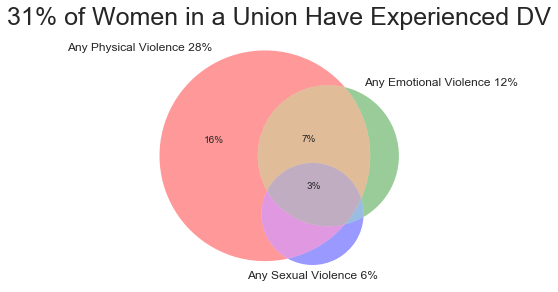

In [20]:
# Make the diagram the venn diagram
plt.figure(figsize=(5,5))
plt.title('31% of Women in a Union Have Experienced DV', fontsize=25)
v = venn3(subsets = (13.3,1.9, 5.6, .8,1.7,.2,2.8), set_labels = ('Any Physical Violence 28%', 'Any Emotional Violence 12%', 'Any Sexual Violence 6%'))
v.get_label_by_id('100').set_text('16%')
v.get_label_by_id('110').set_text('7%')
v.get_label_by_id('111').set_text('3%')
v.get_label_by_id('001').set_text('')
v.get_label_by_id('010').set_text('')
v.get_label_by_id('011').set_text('')
v.get_label_by_id('101').set_text('')
plt.show()

In [21]:
# Create dfs for visualizations

# d102 is number of control issues
df_control  = df_in_union.groupby('d102')['dv'].agg(['mean','count']).reset_index()
df_control['perc'] = df_control['count']*100.0/len(df_in_union)
df_control['mean'] = df_control['mean']*100.0

# v012 is age in complete years
df_age  = df_in_union.groupby('v012')['dv'].agg(['mean','count']).reset_index()
df_age['perc'] = df_age['count']*100.0/len(df_in_union)
df_age['mean'] = df_age['mean']*100.0

# v133 is the number of years of education
#df_educ = pd.DataFrame(df_in_union['dv'].groupby(df_in_union['v133']).mean()).reset_index()
df_educ = df_in_union.groupby('v133')['dv'].agg(['mean','count']).reset_index()
df_educ['perc'] = df_educ['count']*100.0/len(df_in_union)
df_educ['mean'] = df_educ['mean']*100.0

# v133 is the wealth quintile of a household
df_wealth = df_in_union.groupby('wealth')['dv'].agg(['mean','count']).reset_index()
df_wealth['perc']= df_wealth['count']*100.0/len(df_in_union)
df_wealth['mean'] = df_wealth['mean']*100.0

# v743_ questions have to do with who the respondant says has the ability to influence day to day decisions in the househol
df_house_dec = df_in_union.groupby('house_dec')['dv'].agg(['mean','count']).reset_index()
df_house_dec['perc']= df_house_dec['count']*100.0/len(df_in_union)
df_house_dec['mean'] = df_house_dec['mean']*100.0

# Number of reasons a man is justified in beating his wife
df_reasons = df_in_union.groupby('reasons')['dv'].agg(['mean','count']).reset_index()
df_reasons['perc']= df_reasons['count']*100.0/len(df_in_union)
df_reasons['mean'] = df_reasons['mean']*100.0

# Religion
df_rel = df_in_union.groupby('v130')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_rel['perc'] = df_rel['count']*100.0/len(df_in_union)
df_rel['mean'] = df_rel['mean']*100.0
df_rel = df_rel.replace('buddhist/neo-buddhist','buddhist')
df_rel = df_rel[df_rel.v130 != 'jewish']

# Categorical Variables
# How often partner gets drunk
df_drunk = df_in_union.groupby('drunk')['dv'].agg(['mean','count']).reset_index().sort_values('mean').reset_index()
df_drunk['perc'] = df_drunk['count']*100.0/len(df_in_union)
df_drunk['mean'] = df_drunk['mean']*100.0

# Urban vs. Rural
df_urban = df_in_union.groupby('v102')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_urban['perc']= df_urban['count']*100.0/len(df_in_union)
df_urban['mean'] = df_urban['mean']*100.0

# Earnings
df_earnings = df_in_union.groupby('earnings')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_earnings['perc']= df_earnings['count']*100.0/len(df_in_union)
df_earnings['mean'] = df_earnings['mean']*100.0

# State
df_state = df_in_union.groupby('v101')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_state['perc']= df_state['count']*100.0/len(df_in_union)
df_state['mean'] = df_state['mean']*100.0

# Ethnicity
df_ethn = df_in_union.groupby('v131')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_ethn['perc']= df_ethn['count']*100.0/len(df_in_union)
df_ethn['mean'] = df_ethn['mean']*100.0

# Earnings Relative to Husband
df_earn_portion = df_in_union.groupby('v746')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_earn_portion['perc']= df_earn_portion['count']*100.0/len(df_in_union)
df_earn_portion['mean'] = df_earn_portion['mean']*100.0

# News_mags
df_nm = df_in_union.groupby('v157')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_nm['perc']= df_nm['count']*100.0/len(df_in_union)
df_nm['mean'] = df_nm['mean']*100.0

In [22]:
# If you have experienced dv, you are more likely to agree with one or more justifications for wife beating?
df_agree = pd.DataFrame(df_in_union['reasons_thresh'].groupby(df_in_union['dv']).mean()).reset_index()
display(df_agree)

,dv,reasons_thresh
0,0,0.359166
1,1,0.566271


In [23]:
# The more afraid of your husbnd you are, the more reasons for beating you agree with
df_reasons_afraid = df_in_union.groupby('d129')['reasons'].mean()
df_reasons_afraid

d129
0    0.987272
1    1.090542
2    1.589220
Name: reasons, dtype: float64

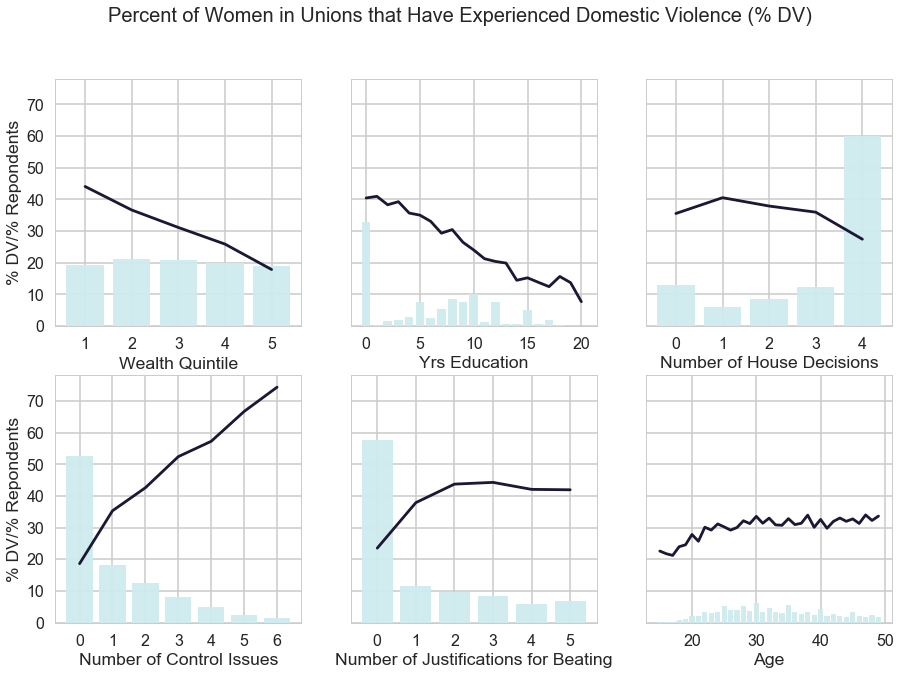

In [24]:
# Make a set of line plots for age, education, and wealth and prev of dv
# Then make a set of histograms to go along with those

m = df_in_union.dv.mean()
#plt.axhline(y=m, xmin=0, xmax=1, hold=None, color="#EE3E3A")

fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.02)

ax1 = plt.subplot(2,3,1)
ax1.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], minor=False)
ax1.set_ylim(0, 80)
plt.plot(df_wealth['wealth'], df_wealth['mean'], color= palette[0])
plt.bar(df_wealth['wealth'], df_wealth['perc'], color= palette[1], alpha = .95)
ax1.set_xticks([1, 2, 3, 4, 5], minor=False)
plt.ylabel('% DV/% Repondents')
plt.xlabel('Wealth Quintile')

ax2 = plt.subplot(2,3,2, sharey=ax1)
plt.plot('v133', 'mean', data=df_educ, color=palette[0])
plt.bar(df_educ['v133'], df_educ['perc'],  color= palette[1], alpha = .95)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.xlabel('Yrs Education')

ax3 = plt.subplot(2,3,3, sharey=ax1)
plt.plot('house_dec', 'mean', data=df_house_dec, color=palette[0])
plt.bar(df_house_dec['house_dec'], df_house_dec['perc'],  color= palette[1], alpha = .95)
ax3.set_xticks([0, 1, 2, 3, 4], minor=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.xlabel('Number of House Decisions')


ax4 = plt.subplot(2,3,4, sharey=ax1)
plt.plot( 'd102', 'mean', data=df_control, color=palette[0])
plt.bar(df_control['d102'], df_control['perc'],  color= palette[1], alpha = .95)
ax4.set_xticks([0, 1, 2, 3, 4, 5, 6], minor=False)
plt.ylabel('% DV/% Repondents')
plt.xlabel('Number of Control Issues')

ax5 = plt.subplot(2,3,5, sharey=ax1)
plt.plot('reasons', 'mean', data=df_reasons, color=palette[0])
plt.bar(df_reasons['reasons'], df_reasons['perc'],  color= palette[1], alpha = .95)
ax5.set_xticks([0, 1, 2, 3, 4, 5], minor=False)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.xlabel('Number of Justifications for Beating')

ax6 = plt.subplot(2,3,6, sharey=ax1)
plt.plot(df_age['v012'], df_age["mean"], color=palette[0])
plt.bar(df_age['v012'], df_age['perc'],  color= palette[1], alpha = .95)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.xlabel("Age")

plt.show()

Text(0,0.5,'')

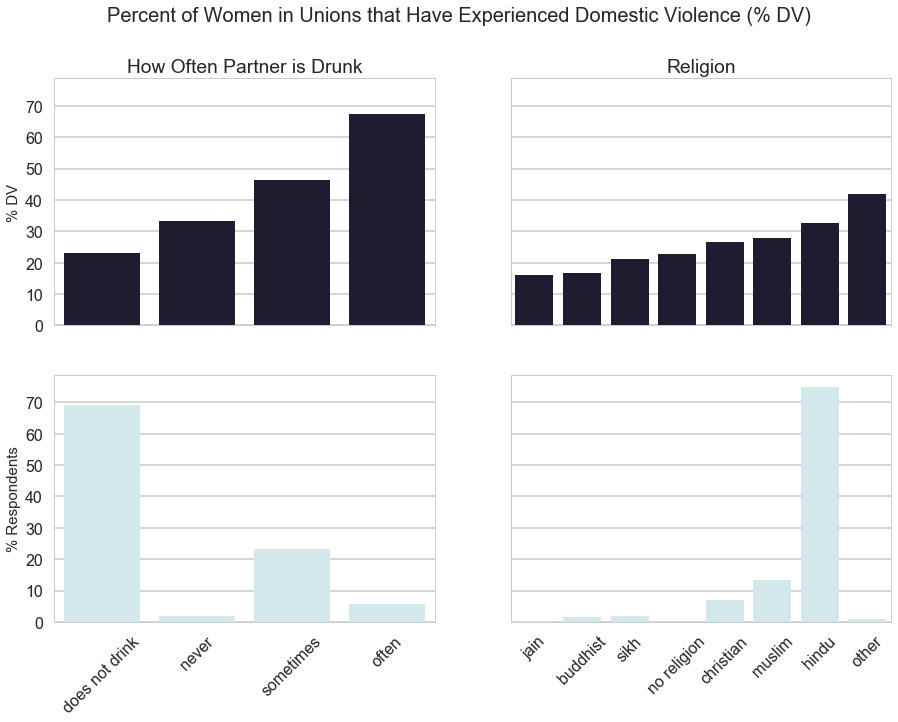

In [25]:
# Visualizations by Categorical Variables
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.57)

# How Often Husband Gets Drunk
ax1 = plt.subplot(2,2,1)
ax1.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], minor=False)
ax1.set_ylim(0, 80)
ax1.set_ylim(0, 80)
plt.xticks(rotation=45)
plt.setp(ax1.get_xticklabels(), visible=False)
sns.barplot(x='drunk', y = 'mean', data = df_drunk ,color= palette[0])
#sns.barplot(x='drunk', y = 'perc', data = df_drunk ,color= palette[1],plot_kws={'bar_kws':{'color':'red'}})
#plt.bar(df_drunk['drunk'], df_drunk['mean'], color= palette[1])
plt.ylabel('% DV',fontsize=15)
plt.xlabel('')
plt.title('How Often Partner is Drunk')

# Drunk Histogram
ax3 = plt.subplot(2,2,3, sharey=ax1)
sns.barplot(x='drunk', y = 'perc', data = df_drunk ,color= palette[1])
plt.xticks(rotation=45)
plt.ylabel('% Respondents',fontsize=15)
plt.xlabel('')

# Religion
ax2 = plt.subplot(2,2,2, sharey=ax1)
sns.barplot(x='v130', y = 'mean', data = df_rel ,color= palette[0])
plt.xticks(rotation=45)
plt.ylabel('% DV',fontsize=15)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('')
plt.title("Religion")

# Religion Histogram
ax4 = plt.subplot(2,2,4, sharey=ax1)
sns.barplot(x='v130', y = 'perc', data = df_rel ,color= palette[1])
plt.xticks(rotation=45)
plt.ylabel('% Respondents',fontsize=15)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('')


Text(0,0.5,'')

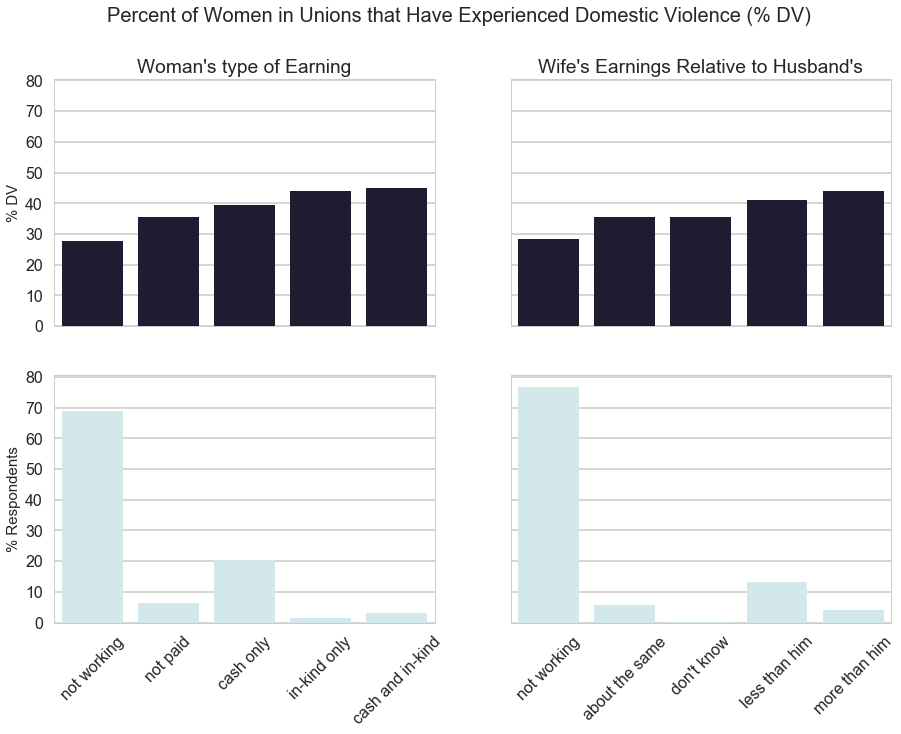

In [26]:
# Visualizations by Categorical Variables
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.57)

# Woman's Type of Earning
ax1 = plt.subplot(2,2,1)
ax1.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], minor=False)
ax1.set_ylim(0, 80)
ax1.set_ylim(0, 80)
plt.xticks(rotation=45)
sns.barplot(x='earnings', y = 'mean', data = df_earnings ,color= palette[0])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('% DV',fontsize=15)
plt.xlabel('')
plt.title("Woman's type of Earning")

# Woman's type of earning histogram
ax3 = plt.subplot(2,2,3, sharey=ax1)
sns.barplot(x='earnings', y = 'perc', data = df_earnings ,color= palette[1])
plt.xticks(rotation=45)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.ylabel('% Respondents',fontsize=15)
plt.xlabel('')

# Earn Portion
df_earn_portion = df_earn_portion.replace({0:"not working"})
ax2 = plt.subplot(2,2,2, sharey=ax1)
sns.barplot(x='v746', y = 'mean', data = df_earn_portion ,color= palette[0])
plt.xticks(rotation=45)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
#plt.ylabel('% DV',fontsize=15)
plt.ylabel('')
plt.xlabel('')
plt.title("Wife's Earnings Relative to Husband's")

#Earn Portion Histogram
ax4 = plt.subplot(2,2,4, sharey=ax1)
sns.barplot(x='v746', y = 'perc', data = df_earn_portion ,color= palette[1])
plt.xticks(rotation=45)
plt.setp(ax4.get_yticklabels(), visible=False)
#plt.ylabel('% Respondents',fontsize=15)
plt.xlabel('')
plt.ylabel('')


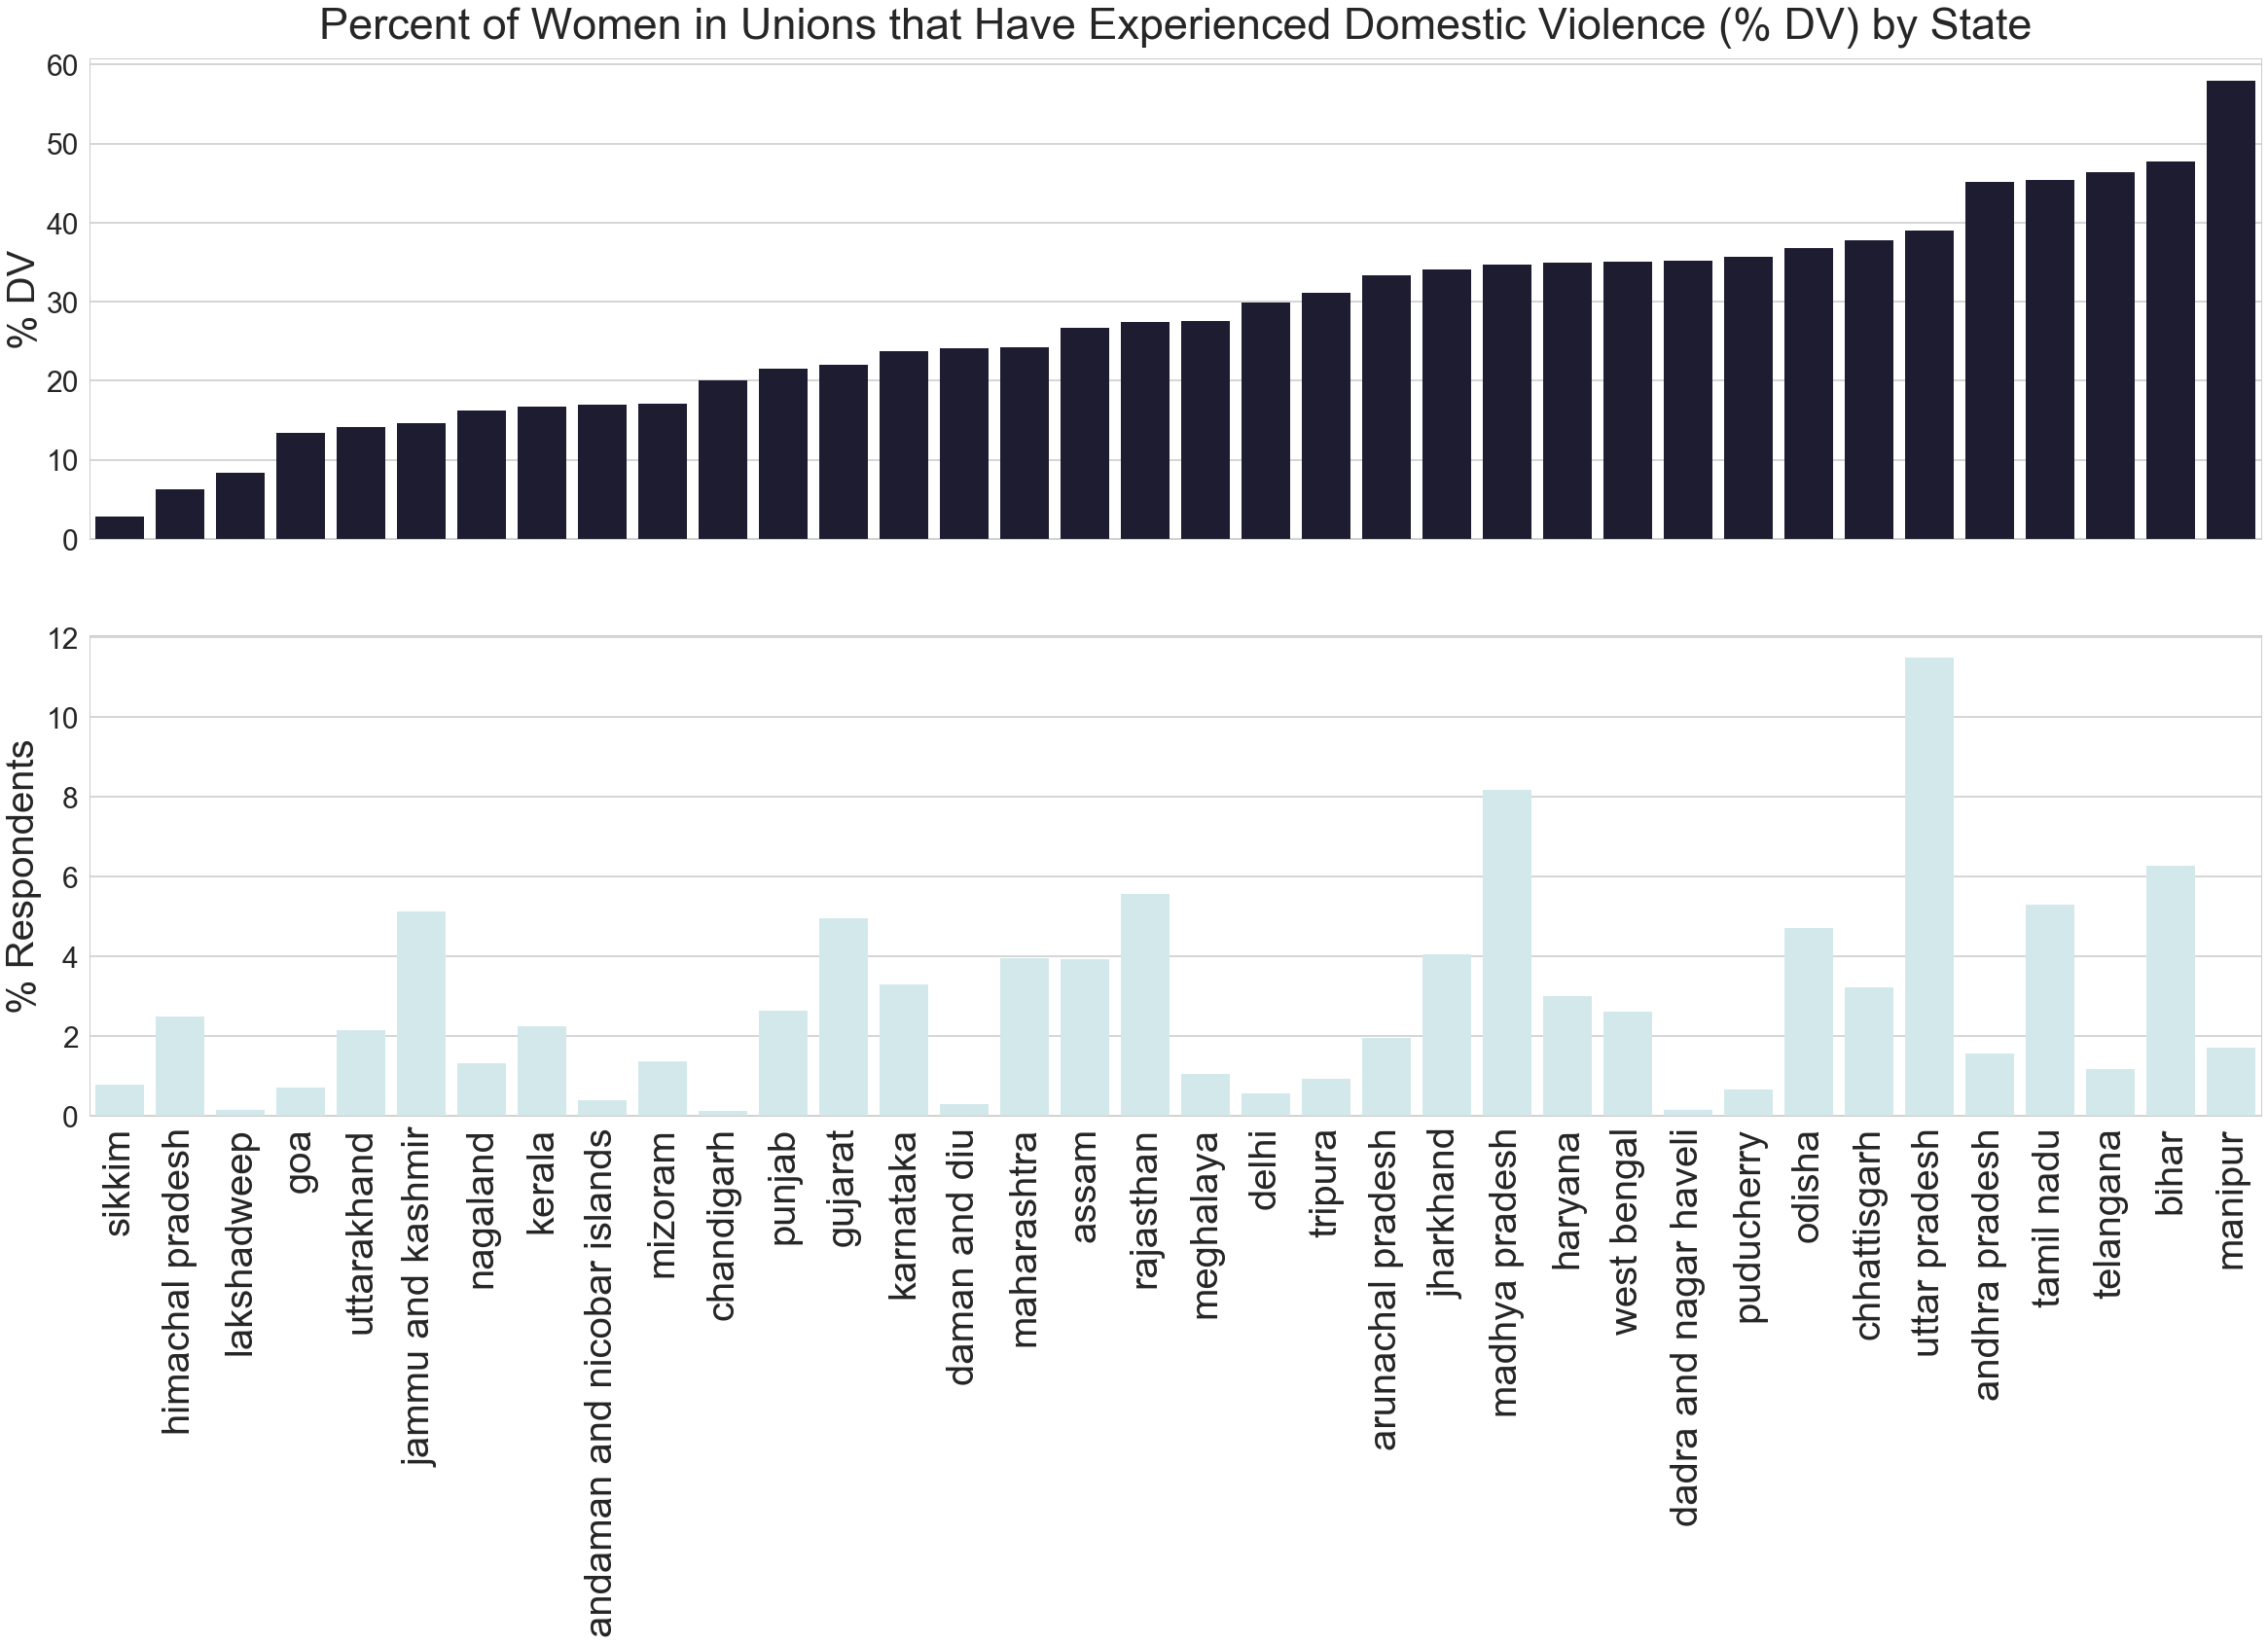

In [27]:
# State
fig = plt.figure(figsize=(40,20))
#st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.57)

# Woman's Type of Earning
ax1 = plt.subplot(2,1,1)
#plt.figure(figsize=(30,15))
sns.barplot(x='v101', y='mean', data=df_state, color = palette[0])
#plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 30)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title('Percent of Women in Unions that Have Experienced Domestic Violence (% DV) by State', fontsize = 45, y=1.03)
plt.ylabel('% DV', fontsize = 40)
plt.xlabel('')

ax2 = plt.subplot(2,1,2)
#plt.figure(figsize=(30,15))
sns.barplot(x='v101', y='perc', data=df_state, color = palette[1])
plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 30)
plt.ylabel('% Respondents', fontsize = 40)
plt.xlabel('')

plt.show()

### Categorical Variables

In [28]:
# Sorting objects variables into categories to be dealt with accordingly
objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)

# List of ordinal variables
ords = ['v745b','v745a','v503','v504','v505','d115','v153','d115y','v746'
        ,'v743f', 'v743d', 'v743b', 'v743a','v741', 'v731', 'd129', 'd114'
        ,'v715', 'v190','d101f', 'drunk','earnings','d121','d119y','d117a'
        ,'d124','d109','d125','v155']

# List of categorical variables
cats = ['v130','v131']

# List to drop during clustering (columns no longer needed, mostly bc of engineered features)
drops = ['v044','caseid','v501','v502','v101', 'v190', 'v102','dv_co'
         ,'v744e', 'v744d', 'v744c', 'v744b', 'v744a','v743f','v743d'
         ,'v743b','v743a','d101f','d101e', 'd101d', 'd101c', 'd101b'
         , 'd101a','v741','drunk','earnings','v034','v121','v120','v157', 'v158','v159','v155']
drops = [item for item in drops if item in df.columns.unique()]

# List of unsorted object variables
print("Still need to sort these before moving on: ",[item for item in objs if item not in (ords + cats + drops)]) 


Still need to sort these before moving on:  []


In [29]:
# Drop list of columns called "drops"
df = df.drop(drops, axis=1)

In [30]:
df.shape

(62006, 109)

In [31]:
# Generating dummy variables from categorical variables and show newly added columns
old_list = df.columns.unique()
cats = [item for item in cats if item in df.columns.unique()]
df = pd.get_dummies(df, columns=cats)
new_list = [item for item in list(df.columns.unique()) if item not in old_list]
new_list

['v130_buddhist/neo-buddhist',
 'v130_christian',
 'v130_hindu',
 'v130_jain',
 'v130_jewish',
 'v130_muslim',
 'v130_no religion',
 'v130_other',
 'v130_sikh',
 'v131_caste',
 "v131_don't know",
 'v131_no caste/tribe',
 'v131_tribe']

In [32]:
# Function that takes an object variable to be converted to binary and a list of values that should be converted to 1s.
def binarify(var, ones):
    
    unique_values = df[var].unique()
    
    zeros = [value for value in unique_values if value not in ones]

    # Only do this transformation if has not already been done
    if df[var].dtype == np.object:

        # Replace values to be numeric and remove na's
        df[var] = np.where(df[var].isin(ones), 1, 0)

        # Select the by row/column pair to select single value and udate the definition
        #data_dict.at[var,'changes'] = '1 = ' + str(ones) + '0 = ' + str(zeros)

        # Current values
        print("New unique values for variable",var,": ", df[var].unique())
        
        # List values that still need to be addressed
        current_objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)
        need_to_binarify = [col for col in ords if col in current_objs]
        print("Ordinals still need to take care of: ", need_to_binarify)

    else:
        # Let user know this variable is already taken care of
        print("Variable", var ," already numerical. Values are: ", df.v745b.unique())
        
        # List values that still need to be addressed
        current_objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)
        need_to_binarify = [col for col in ords if col in current_objs]
        print("Ordinals still need to take care of: ", need_to_binarify)

In [33]:
# 'v153' and 'd115y' both contain answers that would make us want to drop that respondant from the analysis
# v153 = not a de jure resident and  d115y = no response to question

# For each column in df, look at count of respondants that that answered the undersirable answer
not_de_jure = df.isin(['not a de jure resident']).sum().sort_values(ascending = False).to_frame().rename(columns={0: "num_resps"})
not_de_jure = not_de_jure[not_de_jure.num_resps > 0]
display("not_de_jure", not_de_jure)

# For each column in df, look at count of respondants that that answered the undersirable answer
no_response_to_question = df.isin(['no response to question']).sum().sort_values(ascending = False).to_frame().rename(columns={0: "num_resps"})
no_response_to_question = no_response_to_question[no_response_to_question.num_resps > 0]
display("no_response_to_question", no_response_to_question)

'not_de_jure'

,num_resps
v153,1568


'no_response_to_question'

,num_resps
d115y,514


In [34]:
# Replace all values of interest with NaN
df['v153'] = df['v153'].replace('not a de jure resident', np.nan)
df['d115y'] = df['d115y'].replace('no response to question', np.nan)

# Check to make sure na's showed up in right place
print("Check to make sure nans showed up in right place")
#display_count('nulls')

# Drop rows with NAs
df = df.dropna(subset=['v153','d115y'])

# Check to make sure na's showed up in right place
print("Check to make sure nans showed up in right place")
#display_count('nulls')

Check to make sure nans showed up in right place
Check to make sure nans showed up in right place


In [35]:
df.shape

(59934, 120)

In [36]:
# Impact of dropping observations on len(df)
(62716-59934)

2782

In [37]:
# v745b
binarify('v745b', ['alone only', 'both alone and jointly','jointly only'])

# v745a
binarify('v745a',['both alone and jointly', 'jointly only', 'alone only'])

# v503
binarify('v503',['once','more than once'])

# v504
binarify('v504', ['living with her'])

# v504
binarify('v505', ['1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0'])

# d115y
binarify('d115y',['someone physically hurt respondent'])

# v746
binarify('v746',['more than him'])

# v731 Whether the respondent worked in the last 12 months  
binarify('v731',['currently working', 'in the past year', 'have a job, but on leave last 7 days'])

# d121 Did her father ever beat her mother.
binarify('d121',[1])

# d119y Sought help from no on to stop violence (whether or not there was violence)
binarify('d119y',['no help was sought'])

# d124, which says if anyone other that partner forced respondant to perform sexual acts
binarify('d124',[1])

# d125 Anyone forced respondent to perform sexual acts. [0, 1, refused to answer/no response]
binarify('d125',[1])

# Ever told anyone else about violence?
df['d128'] = df['d128'].replace({np.nan:0})

New unique values for variable v745b :  [0 1]
Ordinals still need to take care of:  ['v745a', 'v503', 'v504', 'v505', 'd115y', 'v746', 'v731', 'v715', 'd121', 'd119y', 'd124', 'd109', 'd125']
New unique values for variable v745a :  [0 1]
Ordinals still need to take care of:  ['v503', 'v504', 'v505', 'd115y', 'v746', 'v731', 'v715', 'd121', 'd119y', 'd124', 'd109', 'd125']
New unique values for variable v503 :  [1]
Ordinals still need to take care of:  ['v504', 'v505', 'd115y', 'v746', 'v731', 'v715', 'd121', 'd119y', 'd124', 'd109', 'd125']
New unique values for variable v504 :  [1 0]
Ordinals still need to take care of:  ['v505', 'd115y', 'v746', 'v731', 'v715', 'd121', 'd119y', 'd124', 'd109', 'd125']
New unique values for variable v505 :  [0 1]
Ordinals still need to take care of:  ['d115y', 'v746', 'v731', 'v715', 'd121', 'd119y', 'd124', 'd109', 'd125']
New unique values for variable d115y :  [0 1]
Ordinals still need to take care of:  ['v746', 'v731', 'v715', 'd121', 'd119y', 'd1

In [38]:
display_count(['v715', 'd109'])

,variable,type,dependent,description,unique_values,dtype,final_use,short_description
1,d109,profile,v502,D109 First time it happened. - Physical violence,"[nan, 18.0, 2.0, 1.0, 4.0, 6.0, 0.0, 3.0, 15.0...",object,NaN,d109
104,v715,segment,v501,V715 Most recent husband or partner's educatio...,"[5.0, 12.0, 17.0, 15.0, 9.0, 0.0, 6.0, 11.0, 1...",object,NaN,education_partner


In [39]:
# Mean years of education of partner
part_educ = df.v715
part_educ = part_educ[part_educ != "don't know"].astype('float')
mean_part_educ = np.mean(part_educ)
mean_part_educ

# Number of years of education of most recent partner/husband
df['v715'] = np.where(df.v715 == "don't know", mean_part_educ, df.v715).astype('float')

In [40]:
# Fill in nan's d117a, times hit by other than partner last 12 with 0
df['d117a'] = df['d117a'].fillna(0)


In [41]:
# Check that no segementation columns are objects
print(df.shape)
objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)
print(objs)
display_count(objs)

(59934, 120)
['d109']


,variable,type,dependent,description,unique_values,dtype,final_use,short_description
0,d109,profile,v502,D109 First time it happened. - Physical violence,"[nan, 18.0, 2.0, 1.0, 4.0, 6.0, 0.0, 3.0, 15.0...",object,NaN,d109


# K Means Clustering

In [42]:
# Split variables into groups for segmentation ('xs') and profiling ('profs')
xs = ['dv_phys_level', 'dv_sex','dv_emo', 'd129', 'control','v','d121','reasons_thresh']
profs = ['dv','v','d106','d107','dv_sex','dv_emo','in_union','afraid_most','afraid_sometimes','afraid_never','d102','reasons_thresh'
         ,'d128', 'd119y','v012','v153','v731','hh_health','can_read','news_mags','tv','radio','news_mags_never','tv_never','radio_never'
         ,'wealth','does_not_drink', 'v715','v730', 'v133','v130_hindu','urban']

# If variable is in xs or profs, add that info to the data_dict
data_dict['final_use'] = np.where(data_dict.variable.isin(xs),'xs',np.where(data_dict.variable.isin(profs),'profs',np.nan))

# Creat df_xs, the df to segment respondents on and view data_dict
df_c = df
df_xs = df_c[xs]
display_count(xs)

,variable,type,dependent,description,unique_values,dtype,final_use,short_description
14,d121,segment,NaN,D121 Did her father ever beat her mother.,"[0, 1]",int64,xs,v_between_parents
40,d129,segment,v502,D129 Respondent afraid of husband/partner most...,"[0, 1, 2]",int64,xs,afraid
66,control,NaN,NaN,Number of control behaviors respondents partne...,"[0.0, 0.667, 1.333, 0.333, 1.0, 1.667, 2.0]",float64,xs,NaN
74,reasons_thresh,NaN,NaN,if respondent agrees with one or more justific...,"[0, 1]",int64,xs,NaN
83,dv_phys_level,NaN,NaN,levels of physical violence,"[0, 1, 2]",int64,xs,NaN
84,dv_emo,NaN,NaN,presence of emotional violence,"[0, 1]",int64,xs,NaN
85,dv_sex,NaN,NaN,presence of sexual violence,"[0, 1]",int64,xs,NaN
87,v,NaN,NaN,If woman reported any violence from someone ot...,"[0, 1]",int64,xs,NaN


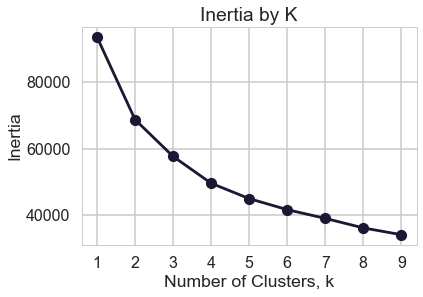

Duration: 0:00:07.241022


In [43]:
#Record start time of processing
start = datetime.datetime.now()

# The best values of SS are found at the "Elbow." 
# The lower the SS, the less distance between data points and their centroid. 
# However, as you increase K, you are bound to decrease SS, but at somepoint overfitting begins.
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(df_xs)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.title('Inertia by K')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

# Record end time of processing and print duration
end = datetime.datetime.now()
print("Duration:", end - start)

In [44]:
# Choose best k by the "elbow" method
best_k = 3

# Add bar chart showing the number of points in each cluster for k-means under the best K

# The slope flattens near 3, so best k = 3. Create model, cluster, with n_clusters = 3.
cluster = KMeans(n_clusters = best_k)

# Add a column to df that is cluster labels from fitting and predicting cluster on df_xs
df_c['cluster'] = cluster.fit_predict(df_xs)

# Find counts of respondents in each cluster
cluster_counts = pd.DataFrame(df_c.groupby('cluster')['d005'].count()).reset_index().rename(index=str, columns={'d005':'cluster_count'}).sort_values('cluster_count')
cluster_counts['cluster_perc'] = np.round((cluster_counts['cluster_count']*100/len(df_c)),1)

# What do different clusters look like?
df_results = np.round(df_c[profs].groupby(df_c['cluster']).mean(),2).reset_index()
df_results['cluster'] = df_results['cluster'].astype('int64')
df_results = pd.merge(df_results, cluster_counts, left_on = 'cluster', right_on = 'cluster')

# Make prettier
df_results = df_results[['cluster','cluster_perc']+profs].rename(index=str, columns=col_name_dict)
df_results['category'] = np.where(df_results['dv']==np.max(df_results['dv']),'Abused',
                                 np.where(df_results['afraid_sometimes']==np.max(df_results['afraid_sometimes']),'In Danger',
                                 'Less Harmed'))
transposed_results = df_results[['category']+ list(df_results.columns.unique())].transpose()
transposed_results


,0,1,2
category,Less Harmed,In Danger,Abused
cluster,0,1,2
cluster_perc,20.4,55.3,24.2
dv,0.13,0.08,1
v,0.02,0.02,0.09
dv_phys_less,0.1,0.03,0.98
dv_phys_more,0,0,0.31
dv_sex,0.02,0.02,0.21
dv_emo,0.03,0.03,0.39
in_union,1,1,1


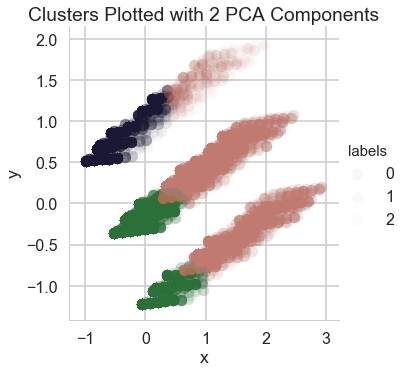

In [45]:
# This function outputs pca_plot with input of matrix, x_col and clf is clustering method
def plot_pca():
    labels = df_c['cluster']
    pca = PCA(n_components = 2)
    pca.fit(df_xs)
    new_matrix = pd.DataFrame(pca.transform(df_xs))
    new_matrix.index = df_xs.index
    new_matrix.columns = ['x','y']
    new_matrix['labels'] = labels

    sns.lmplot(x='x', y='y', hue='labels', data=new_matrix, fit_reg=False, size=5, scatter_kws={'alpha':.03}
               ,palette={0:palette[0], 2:palette[3],1:palette[2]}
              )

# Plot with best_k clusters
plot_pca()
plt.title('Clusters Plotted with 2 PCA Components')
plt.show()

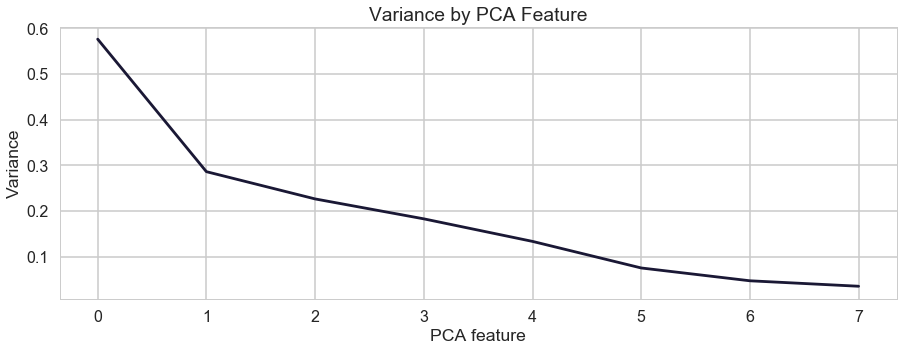

In [46]:
# Create a PCA instance: pca
pca = PCA()

# Fit to x_cols
pca.fit(df_xs)

# Plot the explained variances (Extract the number of components used using the .n_components_ attribute of pca. Place this inside a range() function and store the result as features.)
features = range(pca.n_components_)
plt.figure(figsize=(15,5))
plt.plot(features, pca.explained_variance_)
plt.title('Variance by PCA Feature')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.show()


# Gradient Boosting Classifier
In addition to understanding the ways women expereince domestic violence, we also want to understand what the most important risk factors are. (Maybe what are underlying drivers? What are potential measure for prevention?)



In [47]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    auc_roc = roc_auc_score(y_test, predictions)
    accuracy = sum(np.where(predictions==y_test,1,0))/len(y_test)
    precision = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(predictions)
    recall = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(y_test)
    f1 = (2 * precision * recall)/(precision + recall)
    pos_preds = np.mean(predictions)
    pos_actuals = np.mean(y_test)
    false_negatives = sum(np.where((predictions == 0) & (y_test == 1),1,0))/len(y_test)
    false_positives = sum(np.where((predictions == 1) & (y_test == 0),1,0))/len(y_test)
    
    print('')
    print('Model Performance')
    print('AUC ROC: {:0.1f}'.format(round(auc_roc*100,1)))
    print('F1: {:0.1f}'.format(round(f1*100,1)))
    print('Accuracy: {:0.1f}'.format(round(accuracy*100,1)),'%')
    print('Recall: {:0.1f}'.format(round(recall*100,1)),'%')
    print('Precision: {:0.1f}'.format(round(precision*100,1)),'%')
    print('Positive Predictions: {:0.1f}'.format(round(pos_preds*100,1)),'%')
    print('Positive Actuals: {:0.1f}'.format(round(pos_actuals*100,1)),'%')
    print('False Negatives: {:0.1f}'.format(round(false_negatives*100,1)),'%') 
    print('False Positives: {:0.1f}'.format(round(false_positives*100,1)),'%')

In [48]:
xs = ['d114','v731','v012','v746','v745b','v745a','v730','d121','v715','v714','v505','v504','v133','d102','wealth']
display_count(xs)

,variable,type,dependent,description,unique_values,dtype,final_use,short_description
14,d121,segment,NaN,D121 Did her father ever beat her mother.,"[0, 1]",int64,xs,v_between_parents
17,v133,segment,NaN,V133 Education in single years. This variable ...,"[10, 8, 11, 9, 15, 4, 0, 7, 5, 12, 14, 2, 3, 6...",int64,profs,education
38,v730,segment,v502,V730 Age of the respondent's husband or partne...,"[28.0, 42.0, 51.0, 41.0, 40.0, 37.0, 39.0, 50....",float64,profs,age_partner
39,v505,segment,v502,V505 B Whether the respondent is in a polygyno...,"[0, 1]",int64,nan,in_poly_union
40,v504,segment,v502,V504 Whether the partner lives in the househol...,"[1, 0]",int64,nan,partner_in_hh
44,d102,v034',v502,D102 Number of control issues - Relationship w...,"[0.0, 2.0, 4.0, 1.0, 3.0, 5.0, 6.0]",float64,profs,control_issues
46,d114,segment,"v502, d113",D114 Times partner gets drunk.,"[0, 2, 3, 1]",int64,nan,d114
47,v746,segment,"v502, v731, v741",V746 Whether the respondent earns more than he...,"[0, 1]",int64,nan,earns_more
51,v012,profile,NaN,V012 Current age in completed years,"[22, 40, 37, 33, 35, 27, 34, 28, 36, 32, 25, 2...",int64,profs,age
53,v745b,segment,NaN,V745B Owns land alone or jointly,"[0, 1]",int64,nan,owns_land


In [49]:
# Define features of interest
xs = ['v012',
    'v746',
    'v730',
    'd121',
    'v715',
    'v714',
    'v133',
    'd102',
    'reasons_thresh',
    'house_dec',
    'drunk_freq',
    'does_not_drink',
    'urban',
    'wealth',
    'news_mags_never',
    'v130_buddhist/neo-buddhist',
    'v130_christian',
    'v130_hindu',
    'v130_jain',
    'v130_muslim',
    'v130_no religion',
    'v130_other',
    'v130_sikh',
     ]

# Create arrays for the features and the target: X, y
# Need to add to rename list so they show up correctly in plot
X, y = df.loc[:,xs].rename(index=str, columns=col_name_dict), df.loc[:,'any_v']

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.2, random_state=123)

# XGB requires dmatrix format
#X_train = xgb.DMatrix(X_train, feature_names = list(X_train.columns.unique()))
#y_train = xgb.DMatrix(y_train, feature_names = list(pd.DataFrame(y_train).columns.unique()))
#X_test = xgb.DMatrix(X_test, feature_names = list(X_test.columns.unique()))
#y_test = xgb.DMatrix(y_test, feature_names = list(pd.DataFrame(y_test).columns.unique()))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  4.7min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, early_stopping_rounds=10, eval_metric='auc',
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)
{'colsample_bytree': 0.5, 'max_depth': 7}
0.7921551957887041

Evaluating Randomized Search Model

Model Performance
AUC ROC: 66.9
F1: 53.2
Accuracy: 74.9 %
Recall: 43.7 %
Precision: 67.9 %
Positive Predictions: 21.0 %
Positive Actuals: 32.7 %
False Negatives: 18.4 %
False Positives: 6.7 %


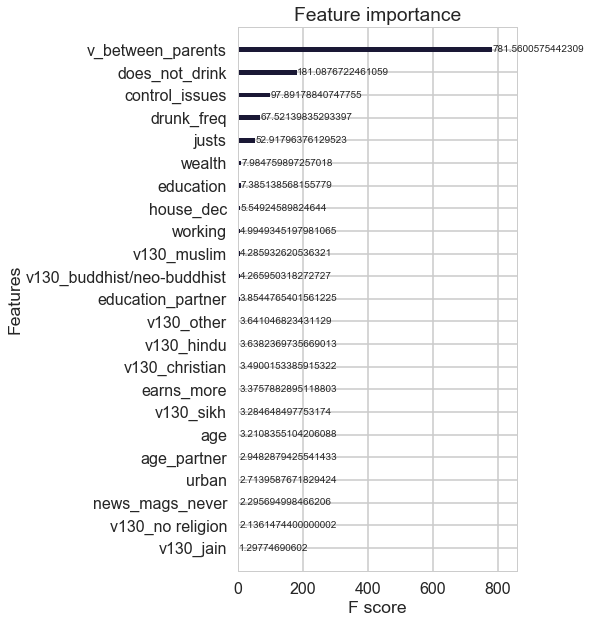

In [ ]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic',
                          seed=42, 
                          learning_rate=0.02, 
                          eval_metric='auc',
                          early_stopping_rounds=10,
                          n_estimators=200
                        )

# Parameter Grid
params = {'max_depth':[1, 5, 7, 10],
          'colsample_bytree':[.1, .3, .5, .75]}

# Grid Search
mse = GridSearchCV(estimator = xg_cl, 
                   param_grid = params,
                   scoring='roc_auc',
                   cv=3,
                   verbose=1)

# Fit the classifier to the training set
mse.fit(X_train, y_train)

# Print Best Parameters Found
print(mse.best_estimator_)
best_params = mse.best_params_
print(mse.best_params_) 
print(mse.best_score_)
print('')

print('Evaluating Randomized Search Model')
best = mse.best_estimator_
evaluate(best, X_test, y_test)

# Feature Importance
#print(best.feature_importances_)
fig, ax = plt.subplots(figsize=(5, 10))
plot_importance(best, ax=ax, importance_type='gain')
plt.show()

In [ ]:
def main():
    names = list(X.columns.unique())

    print("Training GBRT...")
    
    # Use same specifications as for "best"
    clf = GradientBoostingClassifier(
                                     #colsample_bytree=0.5,
                                     max_features=.5,
                                     max_depth=7,
                                     #early_stopping_rounds=10,
                                     validation_fraction=0.2,
                                     n_iter_no_change=10,
                                     #eval_metric='auc',
                                     learning_rate=0.02, 
                                     n_estimators=100, 
                                     random_state=42,
                                     subsample=1
                                    )
    
    
    clf.fit(X_train, y_train)
    print(" done.")

    features = [13,3,7,8,1,5,10,0,2,12,6,4]
    fig, axs = plot_partial_dependence(clf, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, 
                                       grid_resolution=50,
                                       figsize = (15,15)
                                      )
    fig.suptitle('Partial Dependence of Women Experiencing Any Type of Violence (any_v) on Features\n', fontsize=18)
    plt.subplots_adjust(top=0.95)  # tight_layout causes overlap with suptitle

    plt.show()

main()

Training GBRT...


In [ ]:
# Groups of men to convert from abusive-->not abusive, atagnonistic--> not antagonistic, not atagonistic--> advocates
df_m = df_in_union.groupby(['afraid_never','dv'])['dv'].agg(['count']).reset_index()
df_m['perc']= df_m['count']*100.0/len(df_in_union)
df_m